In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')

In [9]:
# fields = ['timestamp', 'm_arch', 'm_pretrain', 'm_finetune', 'p_type', 'p_task'] \
#          + [f'layer{ix}' for ix in [0, 1, 4, 5, 6, 10, 11, 12]]
df = pd.read_csv('data/probe_outputs.csv')

In [10]:
df.head()

,timestamp,m_arch,m_pretrain,m_finetune,p_type,p_task,layer0,layer1,layer4,layer5,layer6,layer10,layer11,layer12
0,2023_03_15-13_17,bert,mlm,none,indiv,pos,0.824708,0.903868,NaN,NaN,0.944248,0.934178,0.928009,0.922941
1,2023_03_15-13_23,bert,mlm,none,cond,pos,0.823708,0.907603,NaN,NaN,0.947649,0.946816,0.944115,0.942481
2,2023_03_15-13_27,bert,mlm,none,indiv,dep,0.600233,0.728676,NaN,NaN,0.829977,0.812738,0.798866,0.777593
3,2023_03_15-13_32,bert,mlm,none,cond,dep,0.599933,0.736579,NaN,NaN,0.833878,0.827709,0.814338,0.798133
4,2023_03_15-13_39,distilbert,mlm,none,indiv,pos,0.824475,0.916906,0.945682,0.93858,0.933845,NaN,NaN,NaN


In [5]:
db_layers = [0, 1, 4, 5, 6]
b_layers = [0, 1, 6, 10, 11, 12]
full_words = {
    'indiv': 'individual',
    'cond': 'conditional',
    'pos': 'part-of-speech',
    'dep': 'dependency'
}

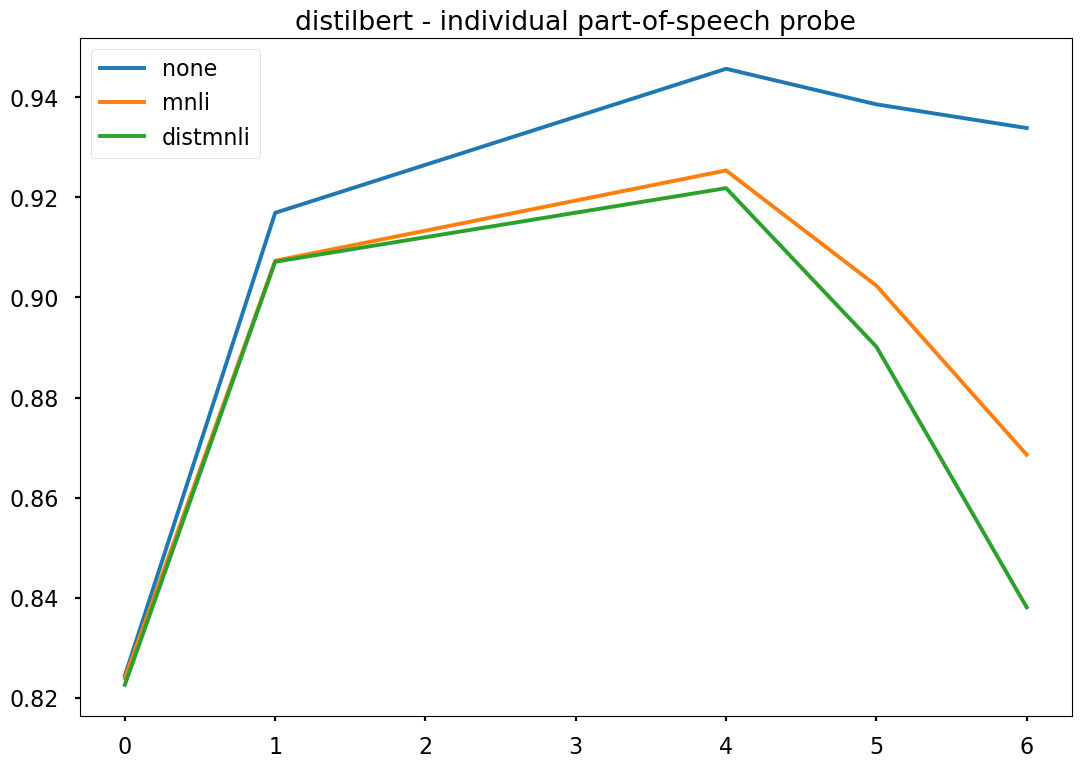

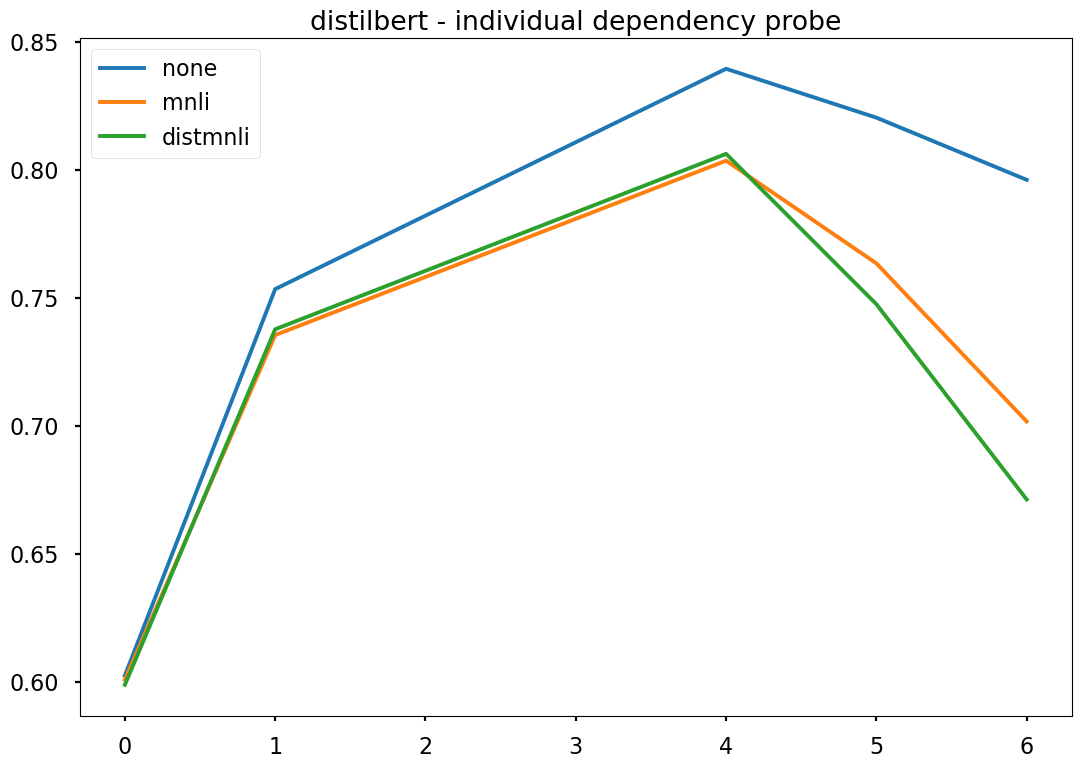

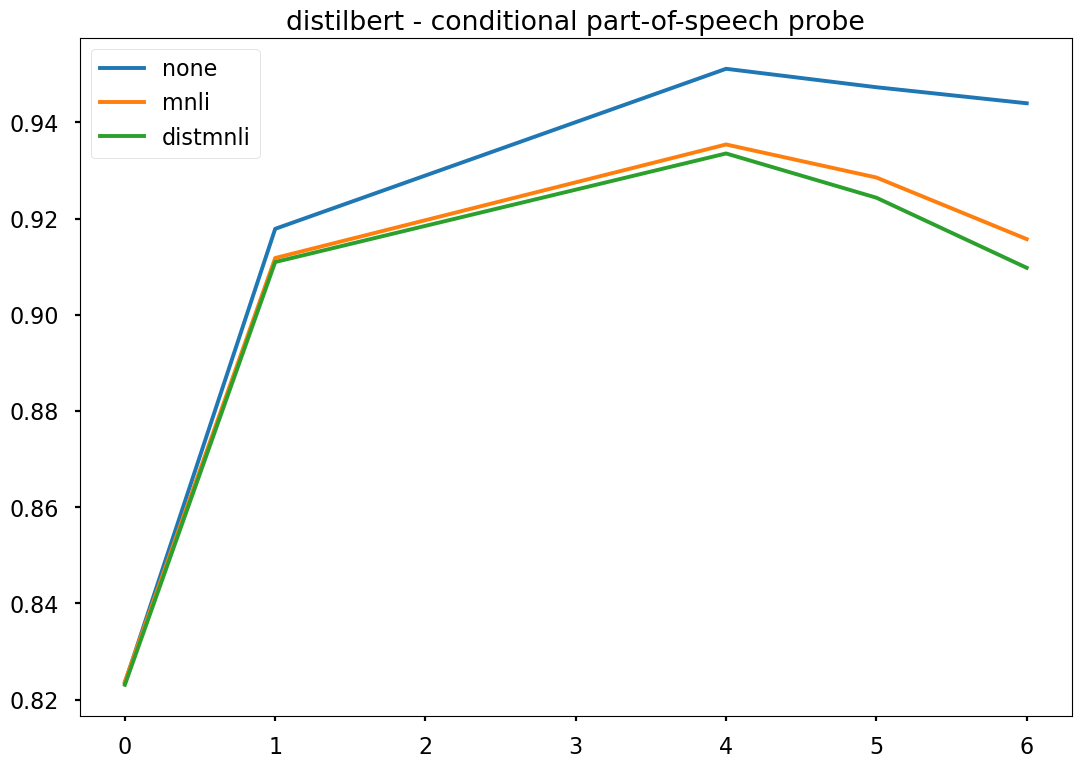

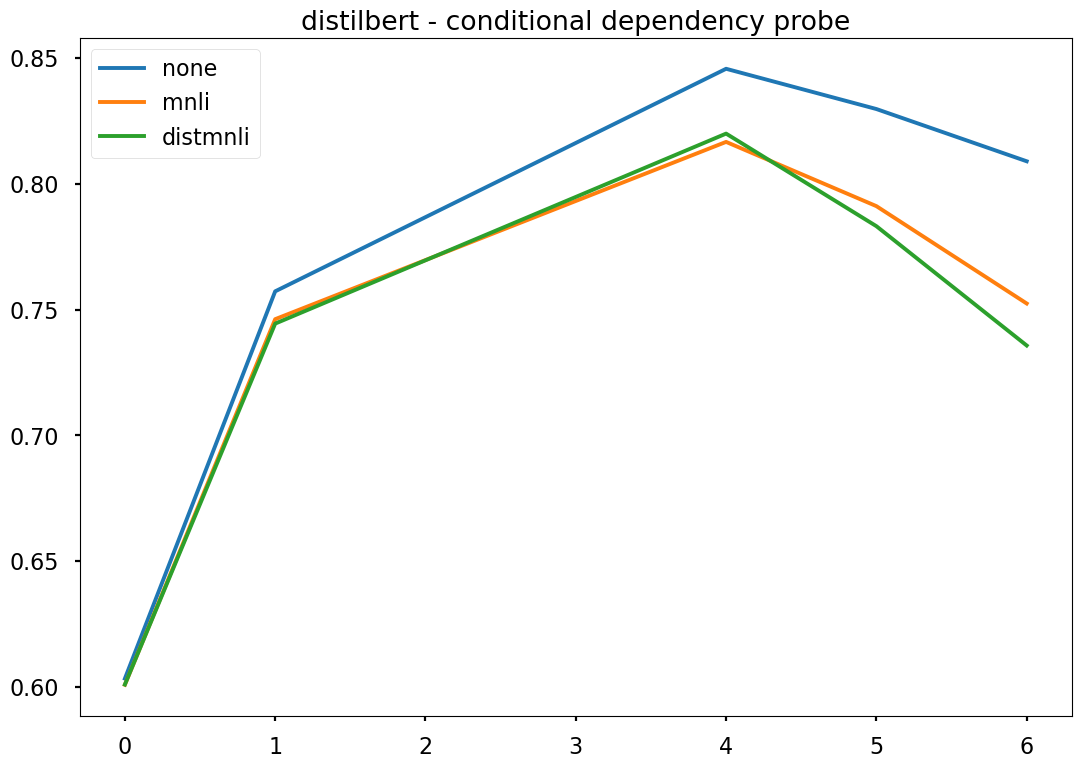

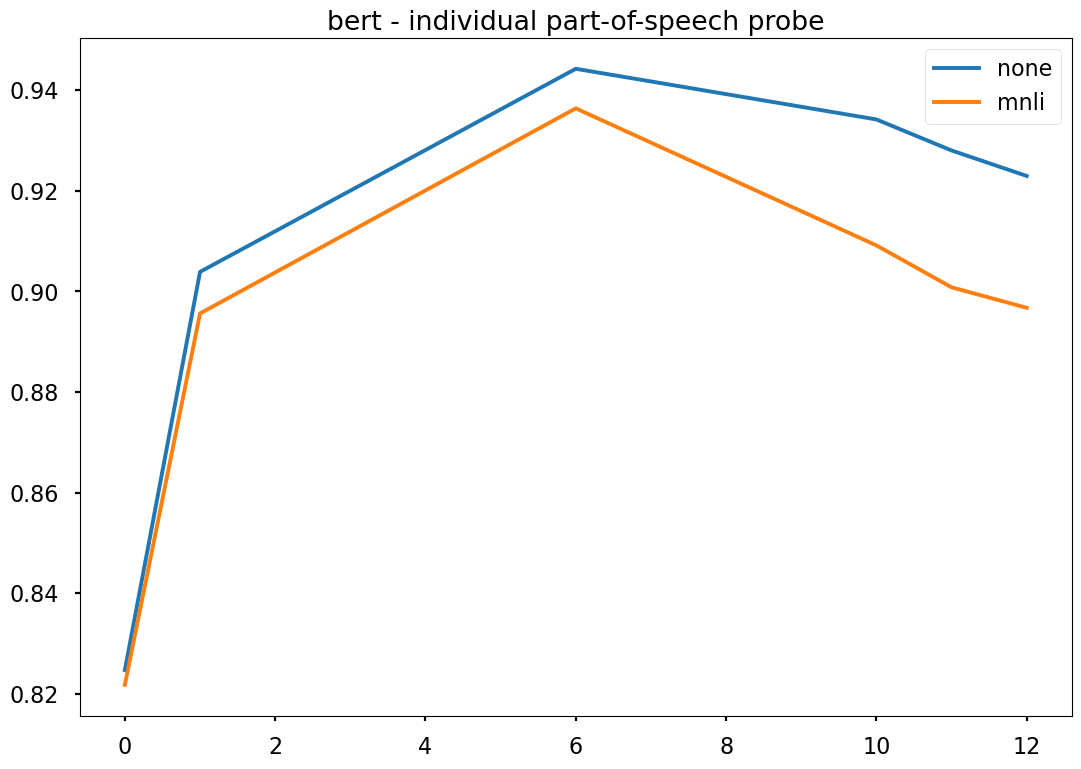

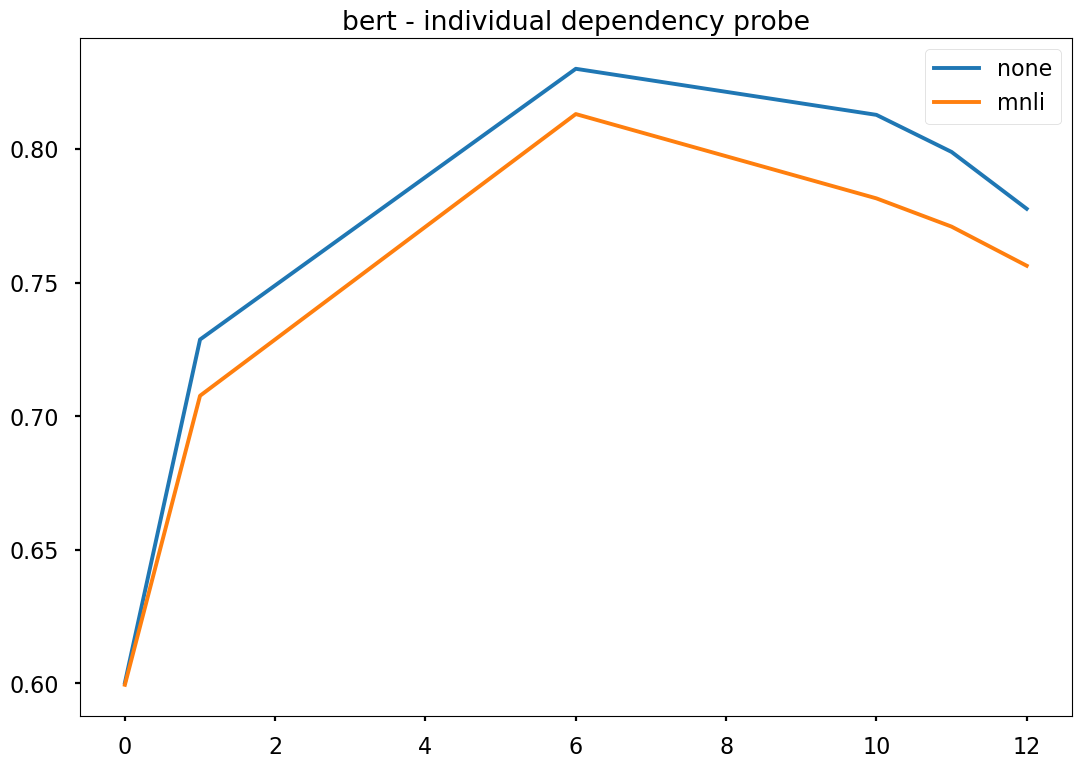

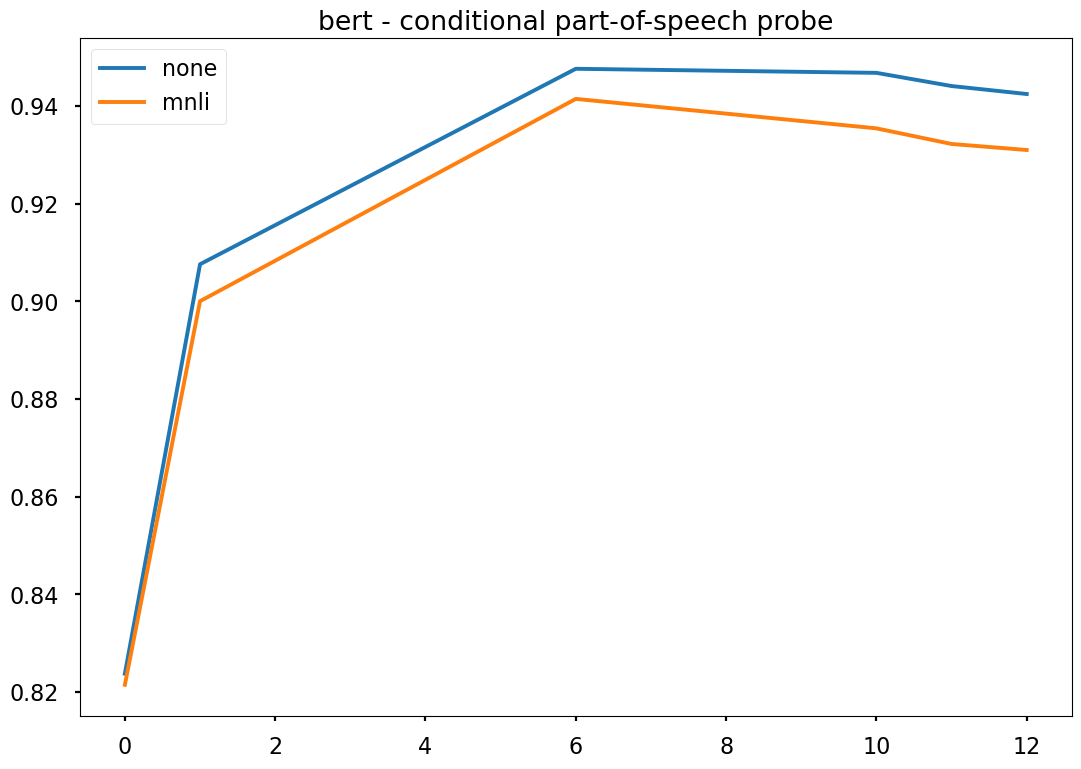

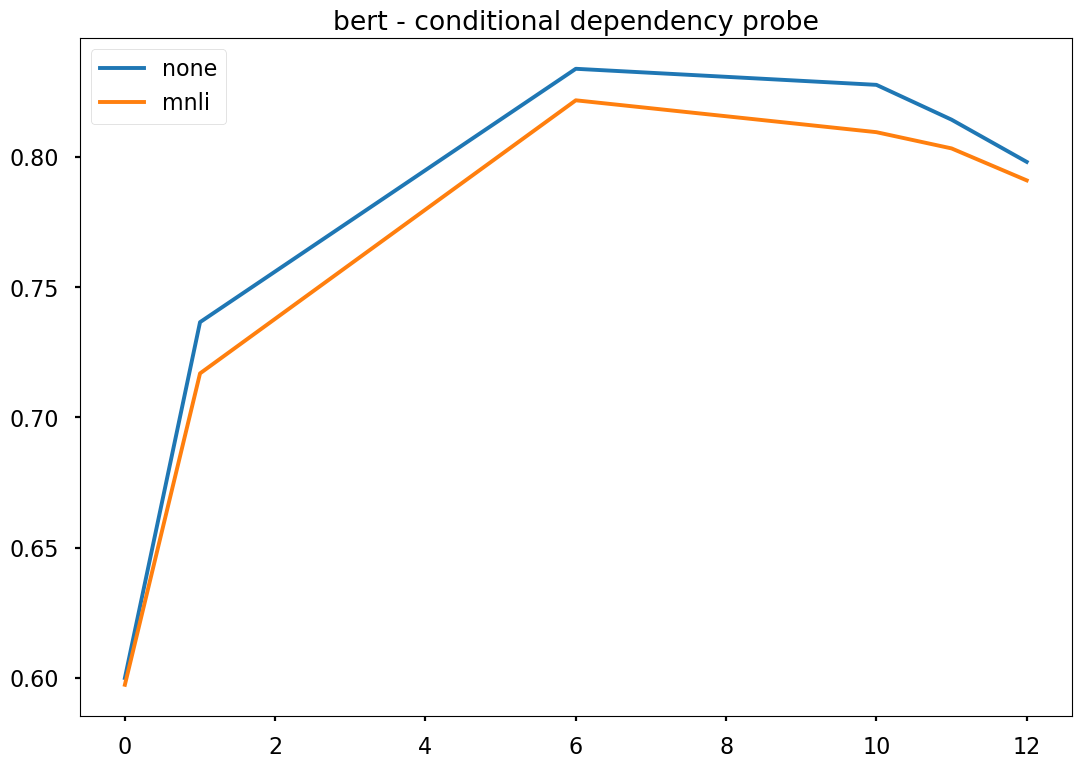

In [6]:

for model in ['distilbert', 'bert']:
    layers = b_layers if model == 'bert' else db_layers
    layer_names = [f'layer{i}' for i in layers]
    for ptype in ['indiv', 'cond']:
        tune_types = ['none', 'mnli']
        if model == 'distilbert':
            tune_types.append('distmnli')
        for t in ['pos', 'dep']:
            subdf = df[(df['m_arch'] == model) & (df['p_type'] == ptype) & (df['p_task'] == t)]
            # display(subdf)
            fig, ax = plt.subplots(1)
            ax.set_title(f"{model} - {full_words[ptype]} {full_words[t]} probe")
            for tt in tune_types:
                data_slice = subdf[subdf['m_finetune'] == tt][layer_names]
                ax.plot(layers, data_slice.values.flatten(), label=tt)
            ax.legend()
            fig.show()
